2026-02-15 08:49:09.101166: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771145349.539376      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771145349.659316      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771145350.556619      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771145350.556655      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771145350.556658      55 computation_placer.cc:177] computation placer alr

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✓ Model created (Base Frozen)
Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Training for 15 epochs...
Epoch 1/15


I0000 00:00:1771145495.722273     121 service.cc:152] XLA service 0x7f94ec002090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1771145495.722324     121 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1771145495.722330     121 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1771145496.528957     121 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1771145519.101002     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1656s 1s/step - accuracy: 0.6441 - auc: 0.6956 - loss: 0.6715 - precision: 0.6390 - recall: 0.6635 - val_accuracy: 0.7990 - val_auc: 0.8810 - val_loss: 0.4798 - val_precision: 0.8381 - val_recall: 0.7413 - learning_rate: 5.0000e-05
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1254s 1s/step - accuracy: 0.7505 - auc: 0.8294 - loss: 0.5346 - precision: 0.7415 - recall: 0.7706 - val_accuracy: 0.8033 - val_auc: 0.8952 - val_loss: 0.4694 - val_precision: 0.8789 - val_recall: 0.7034 - learning_rate: 5.0000e-05
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1231s 985ms/step - accuracy: 0.7844 - auc: 0.8640 - loss: 0.4925 - precision: 0.7784 - recall: 0.7953 - val_accuracy: 0.8041 - val_auc: 0.9056 - val_loss: 0.4627 - val_precision: 0.8992 - val_recall: 0.6849 - learning_rate: 5.0000e-05
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1248s 998ms/step - accuracy: 0.7980 - auc: 0.8784 - loss: 0.4715 - precision: 0.7947 - recall: 0.8050 - val_accuracy: 0.8069 - val_auc: 0.9129 -

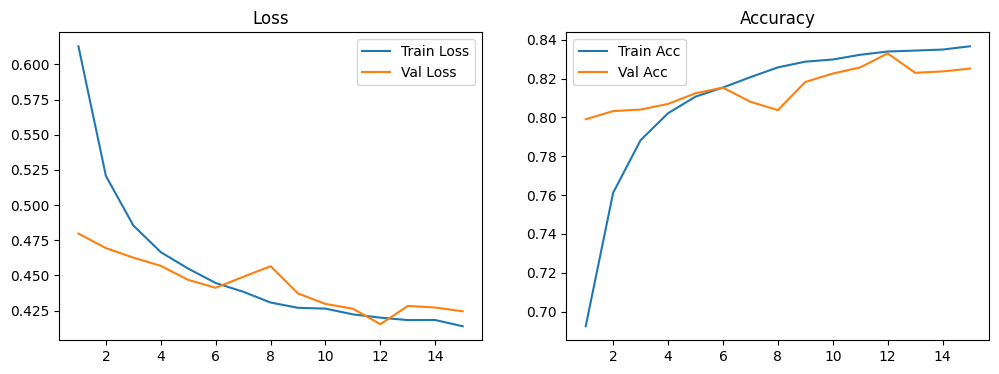

Generating predictions for ROC/PR curves...
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 453ms/step


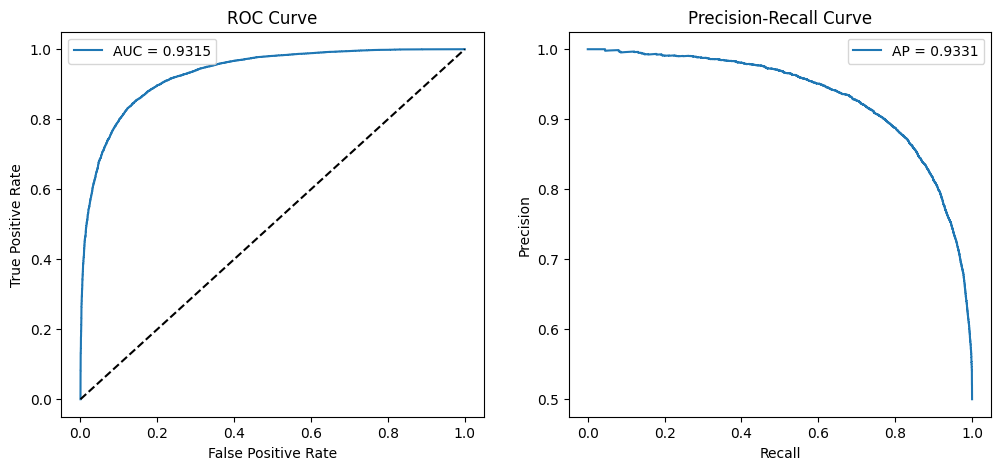

✓ Model saved as VGG16_cifake_final.keras
✓ Model saved as VGG16_cifake_final.h5


In [1]:
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ---------------- CLEAN LOGS ----------------
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

# Set global seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

class RealVsAIClassifier:
    def __init__(self, img_size=(224, 224), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None
        self.base_model = None # Keep reference to base for fine-tuning

    
    # ---------- MODEL ----------
    def create_model(self):
        # Load VGG16 Base
        self.base_model = VGG16(
            input_shape=(*self.img_size, 3),
            include_top=False,
            weights='imagenet'
        )
        self.base_model.trainable = False  # Start frozen

        inputs = keras.Input(shape=(*self.img_size, 3))
        
        # VGG16 specific preprocessing (expects 0-255 inputs)
        x = keras.applications.vgg16.preprocess_input(inputs)
        
        x = self.base_model(x, training=False)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dropout(0.3)(x)
        
        outputs = layers.Dense(1, activation='sigmoid')(x)

        self.model = keras.Model(inputs, outputs)
        self._compile_model(lr=5e-5)
        
        print("✓ Model created (Base Frozen)")

    def _compile_model(self, lr):
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=lr),
            loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
            metrics=[
                'accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc')
            ]
        )

    # ---------- DATA PIPELINE ----------
    def prepare_data_generators(self, train_dir):
        # 1. Training Generator (With Augmentation)
        train_datagen = ImageDataGenerator(
            validation_split=0.2,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            zoom_range=0.2,
            brightness_range=[0.8, 1.2],
            channel_shift_range=30,
            # Note: No rescale needed for VGG16 preprocess_input
        )

        # 2. Validation Generator (No Augmentation - Clean Data)
        val_datagen = ImageDataGenerator(validation_split=0.2)

        # SEED is critical here to ensure the split is the same for both generators
        seed = 42 

        train_gen = train_datagen.flow_from_directory(
            train_dir,
            subset='training',
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            seed=seed,
            shuffle=True
        )

        val_gen = val_datagen.flow_from_directory(
            train_dir,
            subset='validation',
            target_size=self.img_size,
            batch_size=self.batch_size,
            class_mode='binary',
            seed=seed,
            shuffle=False 
        )

        return train_gen, val_gen

    # ---------- FINE TUNING (OPTIONAL) ----------
    def unfreeze_and_finetune(self, train_gen, val_gen):
        print("\n--- Starting Fine-Tuning Phase ---")
        self.base_model.trainable = True
        
        # Freeze all layers except the last block (block5)
        set_trainable = False
        for layer in self.base_model.layers:
            if layer.name == 'block5_conv1':
                set_trainable = True
            if set_trainable:
                layer.trainable = True
            else:
                layer.trainable = False

        # Recompile with a much lower learning rate
        self._compile_model(lr=1e-5)
        
        # Train for a few more epochs
        self.train(train_gen, val_gen, epochs=15, is_finetuning=True)

    # ---------- TRAINING ----------
    def train(self, train_gen, val_gen, epochs=15, is_finetuning=False):
        
        checkpoint_name = 'VGG16_best_model_finetuned.keras' if is_finetuning else 'VGG16_best_model.keras'
        
        callbacks = [
            ModelCheckpoint(f'/kaggle/working/{checkpoint_name}', save_best_only=True, monitor='val_auc', mode='max'),
            EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss'),
            ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-7)
        ]

        print(f"Training for {epochs} epochs...")
        history = self.model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=epochs,
            callbacks=callbacks
        )
        
        # Append history if fine-tuning, else overwrite
        if is_finetuning and self.history:
             for k, v in history.history.items():
                 self.history[k].extend(v)
        else:
            self.history = history.history

    # ---------- PLOTTING ----------
    def plot_results(self, test_gen):
        if not self.history:
            print("No training history to plot.")
            return

        # 1. Loss & Accuracy
        epochs_range = range(1, len(self.history['loss']) + 1)
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        
        ax[0].plot(epochs_range, self.history['loss'], label='Train Loss')
        ax[0].plot(epochs_range, self.history['val_loss'], label='Val Loss')
        ax[0].set_title('Loss')
        ax[0].legend()
        
        ax[1].plot(epochs_range, self.history['accuracy'], label='Train Acc')
        ax[1].plot(epochs_range, self.history['val_accuracy'], label='Val Acc')
        ax[1].set_title('Accuracy')
        ax[1].legend()
        plt.savefig("/kaggle/working/VGG16_accuracy_loss.png", dpi=300, bbox_inches='tight')
        plt.show()

        # 2. ROC & PR Curves
        test_gen.reset()
        y_true = test_gen.classes
        print("Generating predictions for ROC/PR curves...")
        y_pred = self.model.predict(test_gen, verbose=1).ravel()

        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)

        precision, recall, _ = precision_recall_curve(y_true, y_pred)
        ap = average_precision_score(y_true, y_pred)

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        
        # ROC
        ax[0].plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
        ax[0].plot([0, 1], [0, 1], 'k--')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_title('ROC Curve')
        ax[0].legend()

        # Precision-Recall
        ax[1].plot(recall, precision, label=f'AP = {ap:.4f}')
        ax[1].set_xlabel('Recall')
        ax[1].set_ylabel('Precision')
        ax[1].set_title('Precision-Recall Curve')
        ax[1].legend()
        plt.savefig("/kaggle/working/VGG16_roc_pr.png", dpi=300, bbox_inches='tight')
        plt.show()

    def save_final(self):
        self.model.save('/kaggle/working/VGG16_cifake_final.keras')
        print("✓ Model saved as VGG16_cifake_final.keras")
        self.model.save('/kaggle/working/VGG16_cifake_final.h5')
        print("✓ Model saved as VGG16_cifake_final.h5")

# ---------------- MAIN ----------------
def main():
    # Adjust paths as necessary
    BASE_PATH = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images'
    TRAIN_DIR = os.path.join(BASE_PATH, 'train')
    TEST_DIR = os.path.join(BASE_PATH, 'test')

    # Initialize
    classifier = RealVsAIClassifier(img_size=(224, 224), batch_size=64)
    classifier.create_model()

    # Prepare Data
    train_gen, val_gen = classifier.prepare_data_generators(TRAIN_DIR)

    # Phase 1: Train Head (Base Frozen)
    classifier.train(train_gen, val_gen, epochs=15)

    # Phase 2: Fine-Tune (Optional but recommended)
    # classifier.unfreeze_and_finetune(train_gen, val_gen)

    # Test Data Generator (Clean, No Shuffle for metrics)
    test_datagen = ImageDataGenerator()
    test_gen = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(224, 224),
        batch_size=64,
        class_mode='binary',
        shuffle=False 
    )

    # Visualize and Save
    classifier.plot_results(test_gen)
    classifier.save_final()

if __name__ == "__main__":
    main()